In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


### <pi></code>AB Testing Process</Code>
 1. Understanding the business problem and data
 1. data cleaning
 1. Observe summary stats
 1. Apply hypothesis testing and observe assumptions
    - Check Normality and homogenit of the data
    - Apply tests (shapiro, levene, t-tests, Welch test, Mann whitney U test)
 1. Evaluate resuts
 1. Make inferences
 1. Recommned business decisions



## 1. PACKAGES

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import scipy.stats as stats

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## 2. DATA

In [4]:
path = '/kaggle/input/mobile-games-ab-testing/cookie_cats.csv'
def load(path, info = True):
    import pandas as pd
    import numpy as np
    import io
    
    if len(path.split('.csv'))>1:
        read= pd.read_csv(path)
    elif len(path.split('.xlsx'))>1:
        read= pd.read_excel(path)
        
    if len(read)>1:
        print(f''''data imported.
        
        DIMENSIONS 
        {read.shape},
        \n
        dtypes 
        {read.dtypes}
        
        Missing Values.
        \n
        {read.isnull().sum()}''')
        
    else:
        print('NOPE')
    return read
        
        
ab = load(path, info = True)
ab.head()
        
        
        

'data imported.
        
        DIMENSIONS 
        (90189, 5),
        

        dtypes 
        userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
        
        Missing Values.
        

        userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# Number of unique users
print(ab.userid.nunique() == ab.shape[0])

# Summary stats
ab.describe([0.01, 0.05,0.10, 0.20, 0.80, 0.90, 0., 0.99])[['sum_gamerounds']].T

True


,count,mean,std,min,0%,1%,5%,10%,20%,50%,80%,90%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,493.0000,49854.0000


In [6]:
# A/B Group and target summary stats

ab.groupby('version').sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


Text(0.5, 1.0, 'Distribution of Gate 30 & Gate 40')

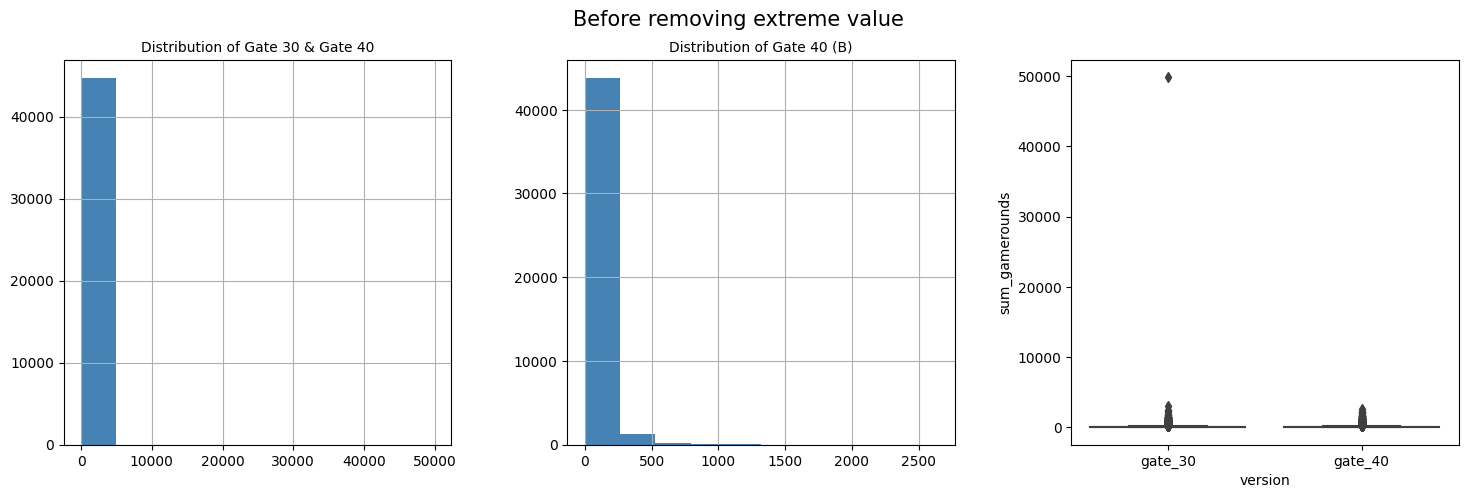

In [7]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
ab[(ab.version == 'gate_30')].hist('sum_gamerounds', ax= axes[0], color='steelblue')
ab[(ab.version == 'gate_40')].hist('sum_gamerounds', ax= axes[1], color='steelblue')
sns.boxplot(x=ab.version, y=ab.sum_gamerounds, ax= axes[2])

plt.suptitle('Before removing extreme value', fontsize = 15)
axes[0].set_title('Distribution of Gate 30 (A)',fontsize = 10)
axes[1].set_title('Distribution of Gate 40 (B)',fontsize = 10)
axes[0].set_title('Distribution of Gate 30 & Gate 40',fontsize = 10)

Text(0.5, 0.98, 'Before removing extreme value')

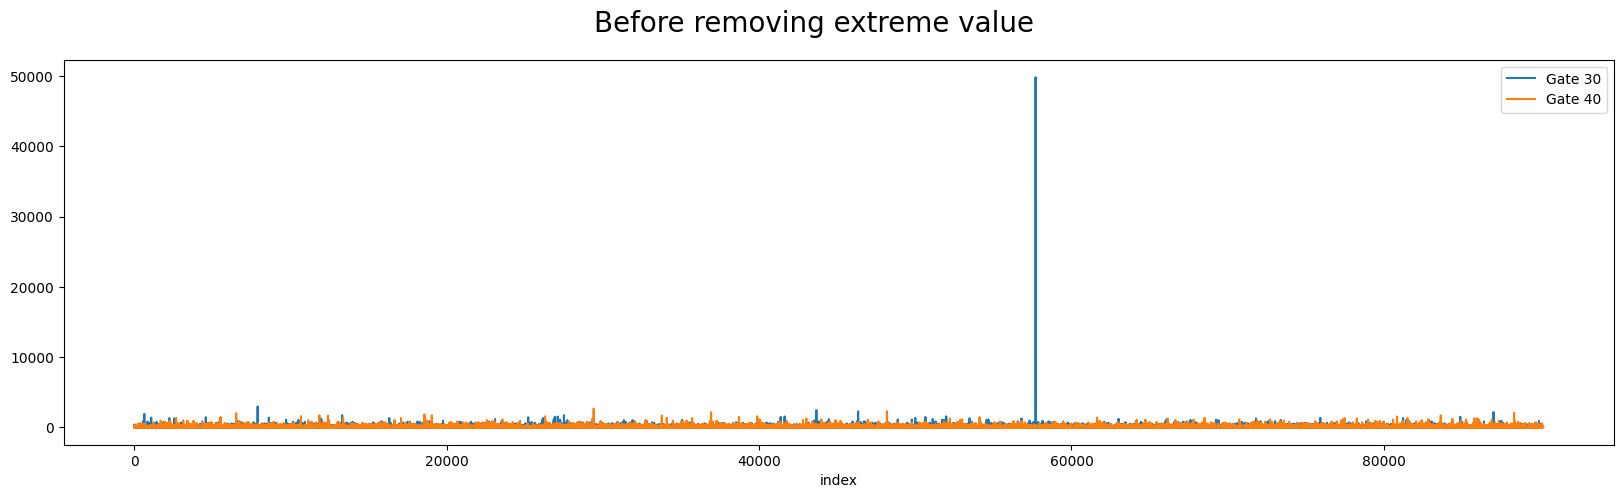

In [8]:
ab[ab.version=='gate_30'].reset_index().set_index('index').sum_gamerounds.plot(legend=True, label='Gate 30', figsize= (20,5))
ab[ab.version=='gate_40'].reset_index().set_index('index').sum_gamerounds.plot(legend=True, label='Gate 40', figsize= (20,5))

plt.suptitle('Before removing extreme value', fontsize=20)

## Outliers

In [9]:
ab= ab[ab.sum_gamerounds< ab.sum_gamerounds.max()] 
ab.describe([0.01, 0.05,0.10, 0.20, 0.80, 0.90, 0., 0.99])[['sum_gamerounds']].T

,count,mean,std,min,0%,1%,5%,10%,20%,50%,80%,90%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,493.0000,2961.0000


Text(0.5, 1.0, 'Distribution of Gate 30 & Gate 40')

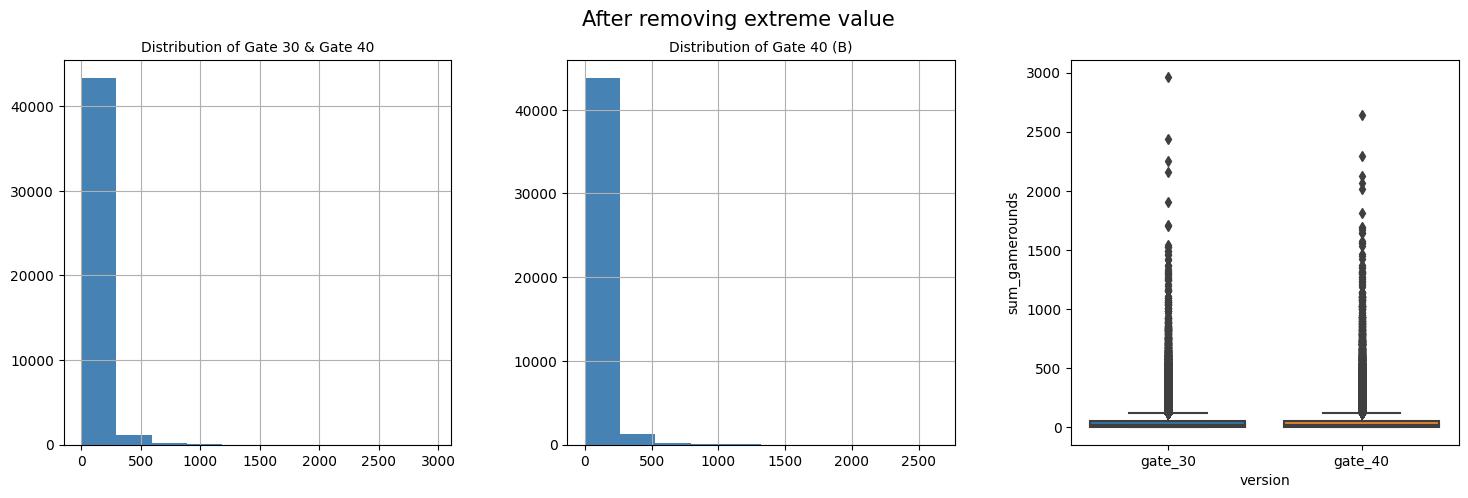

In [10]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
ab[(ab.version == 'gate_30')].hist('sum_gamerounds', ax= axes[0], color='steelblue')
ab[(ab.version == 'gate_40')].hist('sum_gamerounds', ax= axes[1], color='steelblue')
sns.boxplot(x=ab.version, y=ab.sum_gamerounds, ax= axes[2])

plt.suptitle('After removing extreme value', fontsize = 15)
axes[0].set_title('Distribution of Gate 30 (A)',fontsize = 10)
axes[1].set_title('Distribution of Gate 40 (B)',fontsize = 10)
axes[0].set_title('Distribution of Gate 30 & Gate 40',fontsize = 10)

Text(0.5, 0.98, 'After removing extreme value')

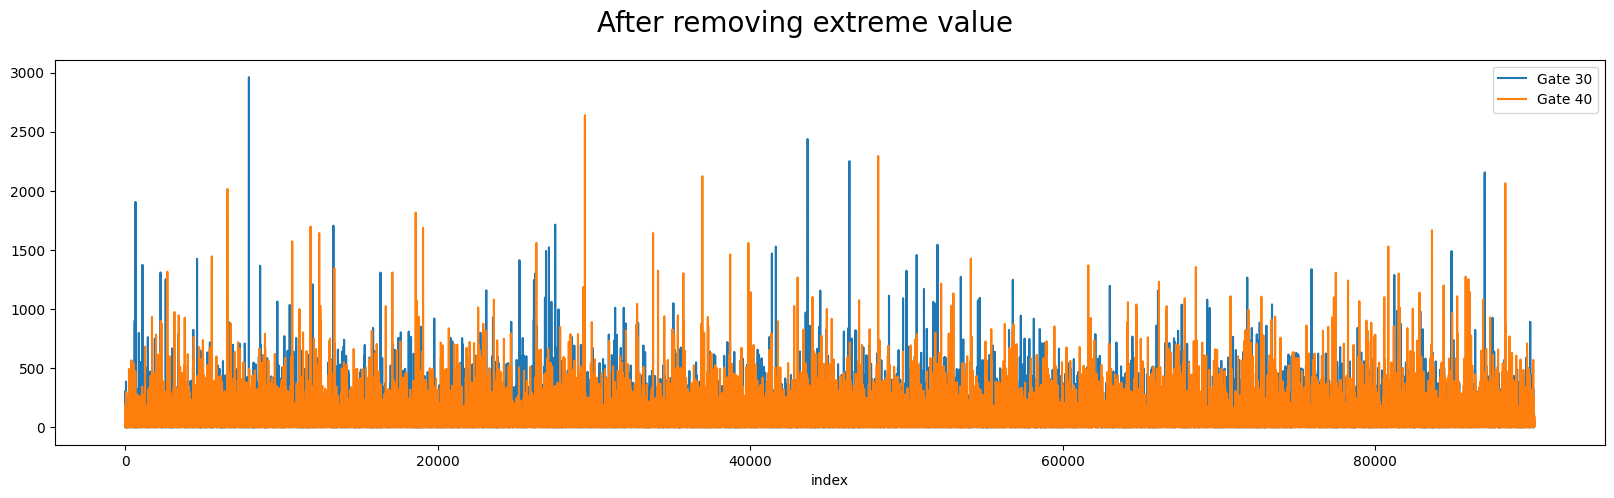

In [11]:
ab[ab.version=='gate_30'].reset_index().set_index('index').sum_gamerounds.plot(legend=True, label='Gate 30', figsize= (20,5))
ab[ab.version=='gate_40'].reset_index().set_index('index').sum_gamerounds.plot(legend=True, label='Gate 40', figsize= (20,5))

plt.suptitle('After removing extreme value', fontsize=20)

<a id='Details'></a>
<h1 style="color:DarkSlateBlue" >SOME DETAILS</h1>

**1. The users installed the game but 3994 players never played**.

**2. Number of users decreases as level Progressed**

Text(0.5, 0.98, 'Number of users in the Game rounds')

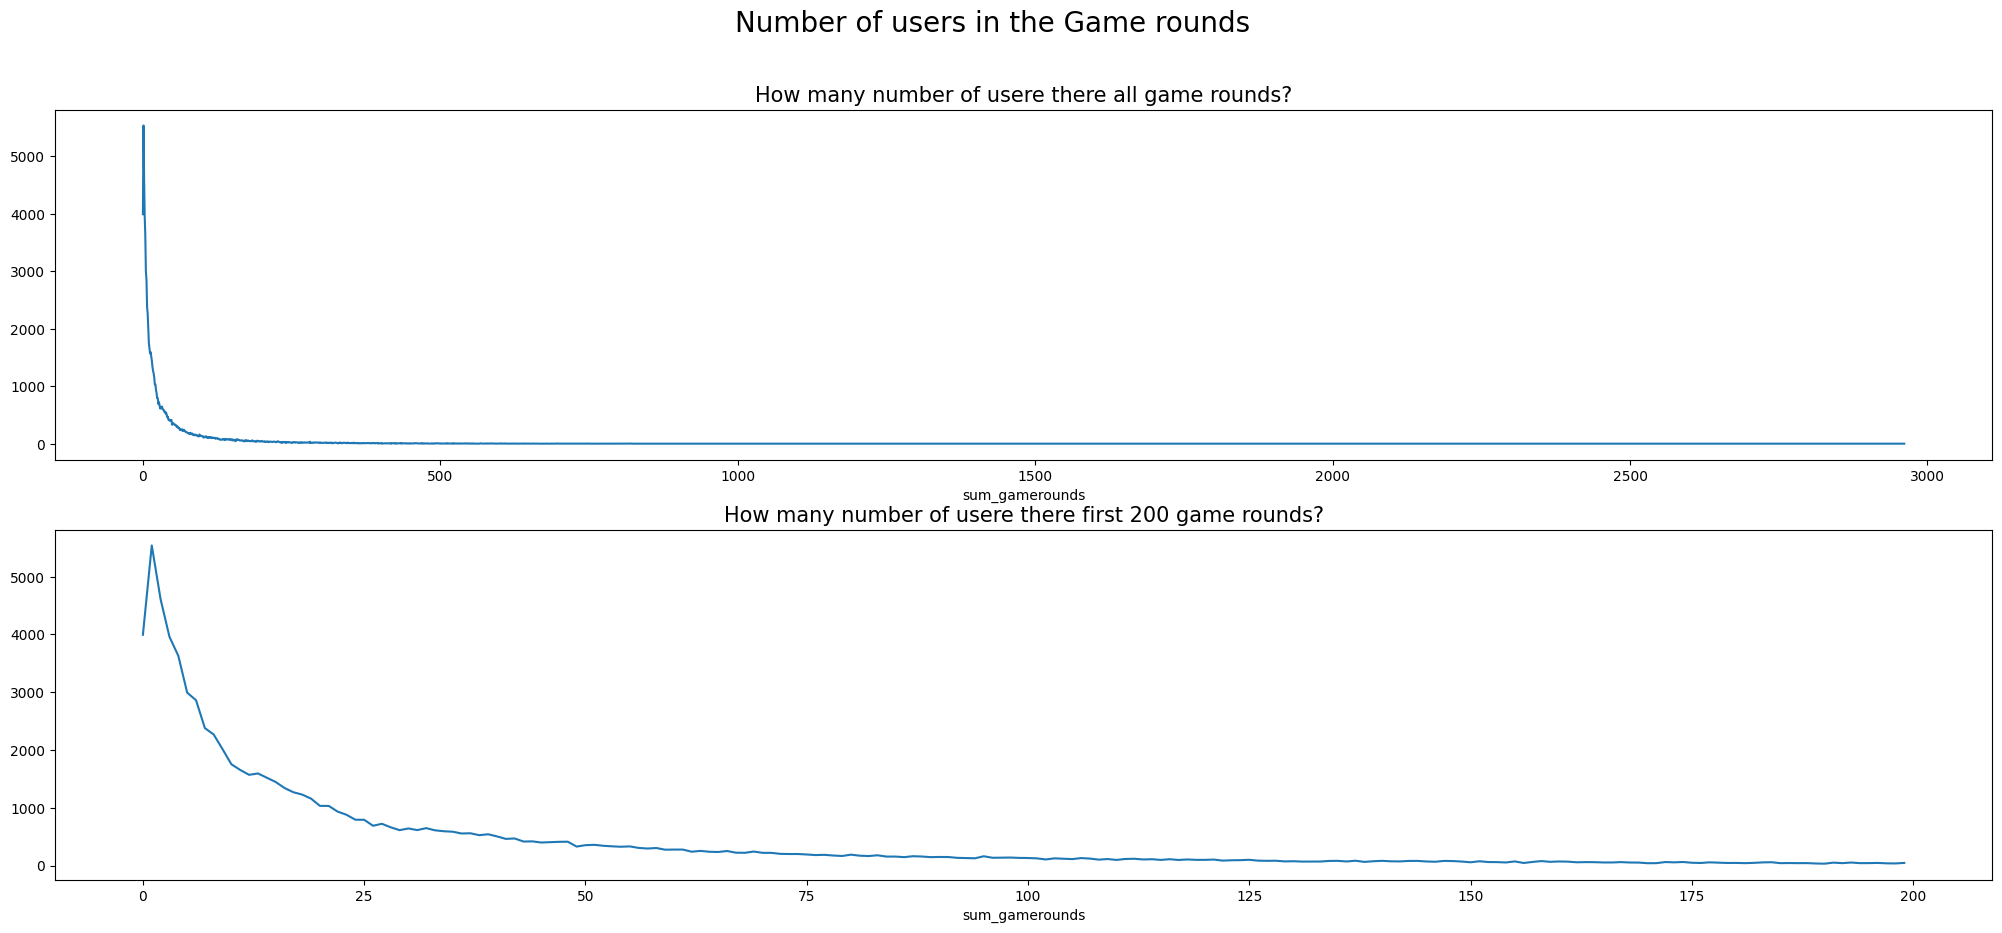

In [12]:
fig,axes = plt.subplots(2,1, figsize=(25,10))
ab.groupby('sum_gamerounds').userid.count().plot(ax= axes[0])
axes[0].set_title('How many number of usere there all game rounds?', fontsize=15)

ab.groupby('sum_gamerounds').userid.count()[:200].plot(ax= axes[1])
axes[1].set_title('How many number of usere there first 200 game rounds?', fontsize=15)

fig.suptitle('Number of users in the Game rounds',fontsize=20)

In [13]:
ab.groupby('sum_gamerounds').userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [14]:
#n reached to lev 30,40
ab.groupby('sum_gamerounds').userid.count().loc[[30,40]].reset_index()

,sum_gamerounds,userid
0,30,642
1,40,505


In [15]:
ab.groupby('version').sum_gamerounds.agg(['count', 'median', 'std', 'max'])

,count,median,std,max
version,,,,
gate_30,44699,17.0000,102.0576,2961
gate_40,45489,16.0000,103.2944,2640


In [16]:
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### **Retention variable gives us player retention details**

In [17]:
pd.DataFrame([ab['retention_1'].value_counts(), ab['retention_1'].value_counts()/len(ab),
             ab['retention_7'].value_counts(), ab['retention_7'].value_counts()/len(ab)])

,False,True
count,50035.0000,40153.0000
count,0.5548,0.4452
count,73408.0000,16780.0000
count,0.8139,0.1861


In [18]:
ab.groupby(['version', 'retention_1']).sum_gamerounds.agg(['count', 'median', 'std', 'max'])

count  median      std   max
version retention_1                              
gate_30 False        24665  6.0000  36.5284  1072
        True         20034 48.0000 135.0377  2961
gate_40 False        25370  6.0000  35.9258  1241
        True         20119 49.0000 137.8873  2640

In [19]:
ab.groupby(['version', 'retention_7']).sum_gamerounds.agg(['count', 'median', 'std', 'max'])

count   median      std   max
version retention_7                               
gate_30 False        36198  11.0000  43.3162   981
        True          8501 105.0000 179.3586  2961
gate_40 False        37210  11.0000  44.4061  2640
        True          8279 111.0000 183.7925  2294

In [20]:
ab['retention'] = np.where((ab.retention_1==True)&(ab.retention_7==True), 1,0)
ab.groupby(['version', 'retention']).sum_gamerounds.agg(['count', 'median', 'std', 'max'])

count   median      std   max
version retention                               
gate_30 0          38023  12.0000  48.0175  1072
        1           6676 127.0000 189.6264  2961
gate_40 0          38983  12.0000  48.9278  2640
        1           6506 133.0000 194.2201  2294

In [21]:
ab['newretention'] = list(map(lambda x,y: str(x)+'-'+str(y), ab.retention_1, ab.retention_7))
ab.groupby(['version', 'newretention']).sum_gamerounds.agg(['count', 'median', 'std', 'max'])

count   median      std   max
version newretention                               
gate_30 False-False   22840   6.0000  21.6426   981
        False-True     1825  43.0000  93.2223  1072
        True-False    13358  33.0000  58.1254   918
        True-True      6676 127.0000 189.6264  2961
gate_40 False-False   23597   6.0000  20.9010   547
        False-True     1773  47.0000  94.4780  1241
        True-False    13613  32.0000  60.9246  2640
        True-True      6506 133.0000 194.2201  2294

<ti> A/B testing
    <li> Check normality
    <li> if normal distribution, check homogeneity

        
<hi> Steps:
    <li> Define control and test group
    <li> Apply shapiro for normality
    <li> If parametric apply Levene test for homogeneity of variences
    <li> If parametric + homogeneity of variences apply t-test
    <li> if parametric - homogeneity of varience apply welch test
    <li> If non-parametric apply mann whitney U test directly 

In [22]:
# Define A/B groups

ab['version'] = np.where(ab.version == 'gate_30', 'A', 'B')
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention,newretention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [30]:
# A/B testing function quick solution
def AB_test(dataframe, group, target):
    
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    groupa = dataframe[dataframe[group] == 'A'][target]
    groupb = dataframe[dataframe[group] == 'B'][target]
    #     Assumption: Normality
    
    
    nta = shapiro(groupa)[1]<0.05
    ntb = shapiro(groupb)[1]<0.05
    # H0 Distribution is normal - False
    # H1 Distribution is not normal - True


    if (nta==False) & (ntb==False): #H0 - Normal Distribution
        #Parametric test
        # Assumption: Homogeneity of variences
        leveneTest = stats.levene(groupa, groupb)[1]<0.05

        #H0: Homogeneity - false'
        #H1: Heterogenious - True
    
    
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupa, groupb, equal_var=True)[1]
            # H0: M1==M2 - False
            # H1:M1 != M2 - True

        else:
    #         Heterogeneity
            ttest= stats.ttest_ind(groupa, groupb, equal_var=False)[1]
            # H0: M1==M2 - False
            # H1:M1 != M2 - True
    else:
        # Non Parametric Test
        ttest= stats.mannwhitneyu(groupa, groupb)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
        #result
    temp = pd.DataFrame({'AB Hypothesis': [ttest<0.05],
                        'P-Value': [ttest]
                        })
    temp['Test Type'] = np.where((nta==False)&(ntb==False), 'Parametric', 'Non-Parametric')
    temp['AB Hypothesis'] = np.where(temp['AB Hypothesis']==False, 'Can not reject H0(H0 is False)', 
                                     'H0 can be rejected (H0 is True)')
    temp['Comment'] = np.where(temp['AB Hypothesis']== 'Can not reject H0(H0 is False)', 
                                     'A/B groups are same', 'No, Both group are different')
    
    if (nta==False) & (ntb==False):
        # Homogeneity
        temp['Homogeneity'] = np.where(levenetest == False, 'yes', 'No')
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "P-Value", "Comment"]]
        
    else:
        temp = temp[["Test Type","AB Hypothesis", "P-Value", "Comment"]]
        
    print('''# A/B Testing Hypothesis
        H0: A==B
        H1: A!=B
        
        ''')
    
    return temp


AB_test(dataframe=ab, group='version', target='sum_gamerounds')


# A/B Testing Hypothesis
        H0: A==B
        H1: A!=B
        
        


,Test Type,AB Hypothesis,P-Value,Comment
0,Non-Parametric,Can not reject H0(H0 is False),0.0509,A/B groups are same


In [38]:
ab.groupby("version").retention_1.mean(), ab.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)